This file: **only** involves calculating storage-needed weights, not for plotting
- 1. Generating distance matrix from raw transcription (for Yubao), and select parts of dialects


In [18]:
import pickle
import numpy as np
import os

data4_dir, data4_dir_matrix = 'Data4/transcription_areas.pkl', 'Data4/distance_matrices.npz'

def list_available_data():
    """
    列出可用的数据集及其包含的特征
    """
    available_data = {
        'Data4': {
            'description': '中国语言资源保护工程',
            'features': [
                'word_name', 'area', 'slice', 'slices', 'coords',
                'initial', 'final', 'tone',
                'initials_distance', 'finals_distance', 'tones_distance', 'overall_distance'
            ]
        }
        # 可以添加其他数据集
    }
    return available_data

def load_feats(name, features=None):
    """
    加载指定数据集的指定特征

    Args:
        name (str): 数据集名称 (e.g., 'Data4')
        features (list, optional): 需要加载的特征列表.
                                     如果为None，则加载所有特征. Defaults to None.

    Returns:
        dict: 包含请求特征的字典
    """
    loaded_data = {}

    if name == 'Data4':
        all_features = [
            'word_name', 'area', 'slice', 'slices', 'coords',
            'initial', 'final', 'tone',
            'initials_distance', 'finals_distance', 'tones_distance', 'overall_distance'
        ]
        if features is None:
            features_to_load = all_features
        else:
            features_to_load = [f for f in features if f in all_features]
            if len(features_to_load) != len(features):
                print(f"Warning: Some requested features for {name} are not available.")

        # 加载 pkl 文件中的数据
        pkl_features = ['word_name', 'area', 'slice', 'slices', 'coords', 'initial', 'final', 'tone']
        if any(f in features_to_load for f in pkl_features):
            try:
                with open(data4_dir, 'rb') as f:
                    data_dict = pickle.load(f)
                if 'initial' in features_to_load:
                     loaded_data['initial'] = data_dict.get('initial')
                if 'final' in features_to_load:
                     loaded_data['final'] = data_dict.get('final')
                if 'tone' in features_to_load:
                     loaded_data['tone'] = data_dict.get('tone')
                if 'word_name' in features_to_load:
                    loaded_data['word_name'] = data_dict.get('word_name')
                if 'area' in features_to_load:
                    loaded_data['area'] = data_dict.get('area')
                if 'slice' in features_to_load:
                    loaded_data['slice'] = data_dict.get('slice')
                if 'slices' in features_to_load:
                    loaded_data['slices'] = data_dict.get('slices')
                if 'coords' in features_to_load:
                    loaded_data['coords'] = data_dict.get('coords')

            except FileNotFoundError:
                print(f"Error: {data4_dir} not found.")
            except Exception as e:
                print(f"Error loading {data4_dir}: {e}")


        # 加载 npz 文件中的数据
        npz_features = ['initials_distance', 'finals_distance', 'tones_distance', 'overall_distance']
        if any(f in features_to_load for f in npz_features):
            try:
                loaded_npz = np.load(data4_dir_matrix)
                if 'initials_distance' in features_to_load:
                    loaded_data['initials_distance'] = loaded_npz.get('initials')
                if 'finals_distance' in features_to_load:
                    loaded_data['finals_distance'] = loaded_npz.get('finals')
                if 'tones_distance' in features_to_load:
                    loaded_data['tones_distance'] = loaded_npz.get('tones')
                if 'overall_distance' in features_to_load:
                     loaded_data['overall_distance'] = loaded_npz.get('overall')
                loaded_npz.close() # Close the npz file

            except FileNotFoundError:
                print(f"Error: {data4_dir_matrix} not found.")
            except Exception as e:
                print(f"Error loading {data4_dir_matrix}: {e}")

    else:
        print(f"Error: Dataset '{name}' not found.")

    return loaded_data

In [63]:
import numpy as np
import pickle
import os # 导入 os 库用于路径拼接

# --- 数据文件路径定义 (请根据你的实际文件位置修改这些路径) ---
# 假设你的数据文件存放在项目根目录下的 data/Data4 文件夹内
# 你可能需要根据实际情况调整这些路径
BASE_DATA_DIR = 'Data4' # 数据文件所在的基准目录

# Data4 的原始转写和元数据 pkl 文件
data4_raw_data_path = os.path.join(BASE_DATA_DIR, 'transcription_areas.pkl') # 假设原始数据文件名是 Data4_raw.pkl
data4_distance_matrix_path = os.path.join(BASE_DATA_DIR, 'distance_matrices.npz') # 假设距离矩阵文件名是 Data4_distance_matrices.npz
# -------------------------------------------------------------


def load_feats(name, type=None, features=None):
    """
    加载指定数据集的指定类型或指定特征的数据。

    Args:
        name (str): 数据集名称 (e.g., 'Data4')
        type (str, optional): 需要加载的数据类型 (e.g., 'raw', 'distance_matrices').
                              如果指定 type，函数会加载该类型下的预定义特征。
                              如果 type 为 None，则必须通过 features 参数指定要加载的特征。
        features (list, optional): 需要加载的特征列表.
                                     如果 type 已指定，features 可用于过滤该类型下的特征。
                                     如果 type 为 None，则加载此列表中指定的特征。
                                     Defaults to None.

    Returns:
        dict: 包含请求特征的字典，键为特征名，值为对应的数据。
              如果加载失败或未找到数据集/类型，返回空字典或 None。
    """
    loaded_data = {}

    # --- 定义不同数据集和类型下的特征列表和文件路径 ---
    # 这个字典定义了每个数据集名称下，不同类型对应哪些预定义特征以及从哪个文件加载
    DATASET_CONFIG = {
        'Data4': {
            'raw': {
                'file': data4_raw_data_path,
                'pkl_keys': ['word_name', 'area', 'slice', 'slices', 'coords', 'initial', 'final', 'tone'],
                'loader': 'pickle' # 指定加载方式
            },
            'distance_matrices': {
                'file': data4_distance_matrix_path,
                'npz_keys': ['initials', 'finals', 'tones', 'overall'], # npz 文件中的键名
                'output_keys': ['initials_distance', 'finals_distance', 'tones_distance', 'overall_distance'], # 输出字典中的键名
                'loader': 'numpy_npz' # 指定加载方式
            },
            # 可以继续添加其他 type...
            # 'another_type': {...}
        }
        # 可以继续添加其他 name...
        # 'AnotherDataset': {...}
    }

    # --- 检查数据集名称是否存在 ---
    if name not in DATASET_CONFIG:
        print(f"错误: 数据集 '{name}' 的配置不存在。")
        return {} # 返回空字典表示失败

    dataset_config = DATASET_CONFIG[name]

    # --- 根据 type 或 features 确定要加载的特征和文件 ---
    features_to_load_final = [] # 最终确定要加载的特征列表
    file_to_load = None
    loader_type = None
    source_keys = {} # 记录源文件中的键名到目标输出键名的映射

    if type:
        if type not in dataset_config:
            print(f"错误: 数据集 '{name}' 不支持类型 '{type}'。")
            return {}

        type_config = dataset_config[type]
        file_to_load = type_config.get('file')
        loader_type = type_config.get('loader')

        if loader_type == 'pickle':
            all_type_features = type_config.get('pkl_keys', [])
            # pickle 加载是直接从字典取，源键和输出键一致
            source_keys = {k: k for k in all_type_features}
        elif loader_type == 'numpy_npz':
            all_type_features = type_config.get('output_keys', [])
            # npz 加载需要处理源键到输出键的映射
            npz_keys = type_config.get('npz_keys', [])
            output_keys = type_config.get('output_keys', [])
            if len(npz_keys) == len(output_keys):
                 source_keys = dict(zip(output_keys, npz_keys)) # 存储 输出键 -> 源键 映射
            else:
                 print(f"配置错误: 数据集 '{name}', 类型 '{type}' 的 npz_keys 和 output_keys 数量不匹配。")
                 return {}
        else:
             print(f"配置错误: 数据集 '{name}', 类型 '{type}' 指定了未知的 loader '{loader_type}'。")
             return {}


        if features is None:
            # 如果没有指定 features，则加载该 type 下的所有预定义特征
            features_to_load_final = all_type_features
        else:
            # 如果指定了 features，则加载该 type 下 features 中包含的特征
            features_to_load_final = [f for f in features if f in all_type_features]
            if len(features_to_load_final) != len(features):
                # 检查用户请求的 features 中是否有不属于该 type 的
                not_available = [f for f in features if f not in all_type_features]
                print(f"警告: 请求的特征 {not_available} 不属于数据集 '{name}' 的类型 '{type}'，将被忽略。")

    elif features is not None:
         # 如果 type 为 None 但指定了 features (旧的使用方式，可以保留兼容性或弃用)
         # 为了新设计清晰，建议要求必须指定 type
         print("错误: 未指定数据加载类型 (type)，请指定如 type='raw'。")
         return {}
         # 以下是保留旧 features 用法的代码，如果需要兼容可以启用：
         # print("警告: 未指定数据类型 (type)，尝试按特征列表加载 (旧模式)。")
         # # 需要遍历所有 type 才能找到哪些特征在哪里，比较复杂，不推荐。
         # # 更好的方式是：要求用户必须指定 type。
         # pass # 在新设计中不推荐无 type 加载

    else:
        # type 和 features 都为 None
        print("错误: 既未指定数据加载类型 (type)，也未指定要加载的特征列表 (features)。")
        return {}


    # --- 执行数据加载 ---
    if not file_to_load:
         print("内部错误: 未能确定要加载的文件路径。")
         return {}

    if not features_to_load_final:
        print(f"未找到需要加载的特征列表，请检查 type 或 features 参数。")
        return {}

    print(f"正在从文件 '{file_to_load}' 加载数据...")
    print(f"计划加载的特征: {features_to_load_final}")

    try:
        if loader_type == 'pickle':
            with open(file_to_load, 'rb') as f:
                data_dict = pickle.load(f)

            for feature_name in features_to_load_final:
                # 从加载的字典中按特征名获取数据
                # 使用 .get() 避免 KeyError 如果文件中的确缺少该特征
                if feature_name in data_dict:
                     loaded_data[feature_name] = data_dict[feature_name]
                else:
                     print(f"警告: 在文件 '{file_to_load}' 中未找到特征 '{feature_name}'。")

        elif loader_type == 'numpy_npz':
            loaded_npz = np.load(file_to_load)
            for output_key in features_to_load_final:
                 source_key = source_keys.get(output_key) # 获取 npz 文件中的对应键
                 if source_key and source_key in loaded_npz:
                     loaded_data[output_key] = loaded_npz[source_key]
                 else:
                     print(f"警告: 在文件 '{file_to_load}' 中未找到特征 '{output_key}' (查找键 '{source_key}')。")
            loaded_npz.close() # 关闭 npz 文件句柄

    except FileNotFoundError:
        print(f"错误: 数据文件 '{file_to_load}' 未找到。请检查路径设置。")
        return {} # 返回空字典表示失败
    except Exception as e:
        print(f"错误加载文件 '{file_to_load}': {e}")
        return {} # 返回空字典表示失败

    print(f"成功加载 {len(loaded_data)} 个特征。")
    return loaded_data


In [66]:
dict_ = load_feats(name='Data4', type='raw')

正在从文件 'Data4/transcription_areas.pkl' 加载数据...
计划加载的特征: ['word_name', 'area', 'slice', 'slices', 'coords', 'initial', 'final', 'tone']
成功加载 8 个特征。


# 1. Data4 

In [19]:
dict = load_feats(name='Data4', features=['initial', 'final', 'tone','word_name', 'area', 'slice', 'slices', 'coords'])
# ['initial', 'final', 'tone', 'word_name', 'area', 'slice', 'slices', 'coords']
initials, finals, tones, word_names, areas, slice, slices, coords = dict['initial'], dict['final'], dict['tone'], dict['word_name'], dict['area'], dict['slice'], dict['slices'], dict['coords']

## 1.1 Calculate and Save Distance Matrix
We first calculate the ratio of missing values of different dialects and features, any only select those with non-missing value above 70%

### 1.1.1 Ratio of Missing Values

In [27]:
import numpy as np

def ratio_missing_transcription(numpy_array, missing_value='MISSING', threshold_percentage=30):
    """
    分析 NumPy 数组中指定缺失值的比例，找出超过阈值的行和列，
    并返回缺失比例最高的各自 Top 10。输出结果使用标准 Python 数字类型。

    Args:
        numpy_array (np.ndarray): 输入的 NumPy 数组，应为二维。
        missing_value (str): 表示缺失值的字符串或值，默认为 'MISSING'。
        threshold_percentage (int or float): 缺失值比例阈值 (0-100)，
                                            超过此比例的行/列会被单独列出。默认为 30。

    Returns:
        dict: 包含分析结果的字典，键值如下：
            'rows_over_threshold': 缺失比例超过阈值的行索引列表 (Python int)。
            'cols_over_threshold': 缺失比例超过阈值的列索引列表 (Python int)。
            'top10_rows': 缺失比例最高的 Top 10 行 (索引, 比例) 列表。
                           格式为 [(行索引: Python int, 缺失百分比: Python float), ...]。
            'top10_cols': 缺失比例最高的 Top 10 列 (索引, 比例) 列表。
                           格式为 [(列索引: Python int, 缺失百分比: Python float), ...]。
        None: 如果输入不是二维 NumPy 数组，则返回 None 并打印错误信息。
    """
    if not isinstance(numpy_array, np.ndarray) or numpy_array.ndim != 2:
        print("错误：输入必须是一个二维 NumPy 数组。")
        return None

    n_rows, n_cols = numpy_array.shape
    print(f"正在分析一个 {n_rows} 行, {n_cols} 列的数组...")
    print(f"缺失值标记为: '{missing_value}'")
    print(f"缺失比例阈值为: {threshold_percentage}%")

    # 创建一个布尔掩码，标记出所有缺失值的位置
    missing_mask = (numpy_array == missing_value)

    # --- 计算每行的缺失比例 ---
    row_missing_counts = np.sum(missing_mask, axis=1)
    row_missing_percentages = (row_missing_counts / n_cols) * 100

    # --- 计算每列的缺失比例 ---
    col_missing_counts = np.sum(missing_mask, axis=0)
    col_missing_percentages = (col_missing_counts / n_rows) * 100

    print("缺失比例计算完成。")

    # --- 找出比例超过阈值的行和列 ---
    # 转换为标准 Python int 列表
    rows_over_threshold_indices = [int(i) for i in np.where(row_missing_percentages > threshold_percentage)[0]]
    cols_over_threshold_indices = [int(i) for i in np.where(col_missing_percentages > threshold_percentage)[0]]

    print(f"发现 {len(rows_over_threshold_indices)} 行的缺失比例超过 {threshold_percentage}%。")
    print(f"发现 {len(cols_over_threshold_indices)} 列的缺失比例超过 {threshold_percentage}%。")

    # --- 找出缺失比例最高的 Top 10 行 ---
    top10_row_indices = np.argsort(-row_missing_percentages)[:10]
    top10_row_percentages = row_missing_percentages[top10_row_indices]
    # 转换为标准 Python int 和 float 元组列表
    top10_rows_result = [(int(idx), float(round(pct, 2))) for idx, pct in zip(top10_row_indices, top10_row_percentages)]

    # --- 找出缺失比例最高的 Top 10 列 ---
    top10_col_indices = np.argsort(-col_missing_percentages)[:10]
    top10_col_percentages = col_missing_percentages[top10_col_indices]
    # 转换为标准 Python int 和 float 元组列表
    top10_cols_result = [(int(idx), float(round(pct, 2))) for idx, pct in zip(top10_col_indices, top10_col_percentages)]

    print("Top 10 缺失比例行/列计算完成。")

    # --- 构建结果字典 ---
    results = {
        'rows_over_threshold': rows_over_threshold_indices,
        'cols_over_threshold': cols_over_threshold_indices,
        'top10_rows': top10_rows_result,
        'top10_cols': top10_cols_result,
    }

    return results

In [48]:
results_initials = ratio_missing_transcription(initials, missing_value='MISSING', threshold_percentage=20)

正在分析一个 1289 行, 999 列的数组...
缺失值标记为: 'MISSING'
缺失比例阈值为: 20%
缺失比例计算完成。
发现 6 行的缺失比例超过 20%。
发现 2 列的缺失比例超过 20%。
Top 10 缺失比例行/列计算完成。


In [49]:
results_finals = ratio_missing_transcription(finals, missing_value='MISSING', threshold_percentage=20)

正在分析一个 1289 行, 999 列的数组...
缺失值标记为: 'MISSING'
缺失比例阈值为: 20%
缺失比例计算完成。
发现 186 行的缺失比例超过 20%。
发现 84 列的缺失比例超过 20%。
Top 10 缺失比例行/列计算完成。


In [50]:
results_tones = ratio_missing_transcription(tones, missing_value='MISSING', threshold_percentage=20)

正在分析一个 1289 行, 999 列的数组...
缺失值标记为: 'MISSING'
缺失比例阈值为: 20%
缺失比例计算完成。
发现 23 行的缺失比例超过 20%。
发现 2 列的缺失比例超过 20%。
Top 10 缺失比例行/列计算完成。


In [51]:
# first operate dialects 
all_row_indices = results_initials['rows_over_threshold'] + results_finals['rows_over_threshold'] + results_tones['rows_over_threshold']
unique_row_indices_set = set(all_row_indices)
unique_row_indices_list = list(unique_row_indices_set)
print(len(unique_row_indices_list), unique_row_indices_list)

all_col_indices = results_initials['cols_over_threshold'] + results_finals['cols_over_threshold'] + results_tones['cols_over_threshold']
unique_col_indices_set = set(all_col_indices)
unique_col_indices_list = list(unique_col_indices_set)
print(len(unique_col_indices_list), unique_col_indices_list)

205 [7, 520, 524, 14, 1039, 17, 533, 535, 541, 31, 550, 551, 40, 41, 553, 555, 556, 559, 561, 562, 563, 564, 565, 568, 574, 575, 1087, 580, 583, 585, 586, 587, 76, 588, 81, 1105, 83, 595, 596, 87, 599, 604, 1117, 94, 606, 1124, 101, 104, 108, 111, 112, 113, 114, 115, 1138, 118, 1144, 121, 1147, 125, 131, 132, 644, 134, 1155, 138, 141, 144, 145, 146, 656, 148, 149, 150, 151, 153, 1178, 669, 158, 159, 1185, 673, 165, 677, 168, 1193, 170, 171, 172, 174, 1199, 176, 1200, 178, 692, 1205, 1211, 187, 189, 1213, 192, 705, 196, 197, 710, 1221, 1224, 1226, 204, 1230, 719, 1231, 724, 734, 1248, 1250, 1251, 1259, 1263, 1264, 1273, 1274, 254, 1282, 259, 1284, 1286, 1288, 277, 286, 288, 801, 296, 331, 848, 850, 853, 345, 347, 859, 864, 865, 873, 878, 372, 886, 890, 378, 380, 386, 387, 904, 397, 398, 911, 913, 405, 408, 409, 412, 928, 932, 422, 424, 425, 427, 428, 431, 432, 434, 439, 441, 958, 961, 450, 963, 964, 965, 969, 459, 460, 971, 974, 972, 973, 976, 982, 983, 473, 1016, 988, 476, 477, 479, 48

In [52]:
import numpy as np

def remove_rows_and_cols(numpy_array, rows_to_delete, cols_to_delete):
    """
    从一个二维 NumPy 数组中删除指定的行和列。

    Args:
        numpy_array (np.ndarray): 输入的二维 NumPy 数组。
        rows_to_delete (list or array_like): 要删除的行的索引列表或数组。
        cols_to_delete (list or array_like): 要删除的列的索引列表或数组。

    Returns:
        np.ndarray: 删除指定行和列后的新的 NumPy 数组。
        None: 如果输入不是二维 NumPy 数组，则返回 None 并打印错误信息。
    """
    if not isinstance(numpy_array, np.ndarray) or numpy_array.ndim != 2:
        print("错误：输入必须是一个二维 NumPy 数组。")
        return None

    print(f"原始数组维度: {numpy_array.shape}")
    print(f"将删除 {len(rows_to_delete)} 行和 {len(cols_to_delete)} 列...")

    # 使用 np.delete 删除行
    # axis=0 表示删除行
    # 返回一个新的数组，原始数组不变
    array_after_rows_deleted = np.delete(numpy_array, rows_to_delete, axis=0)

    # 使用 np.delete 删除列
    # 注意：这里是在删除行后的新数组上操作
    # axis=1 表示删除列
    array_after_cols_deleted = np.delete(array_after_rows_deleted, cols_to_delete, axis=1)

    print(f"删除后的数组维度: {array_after_cols_deleted.shape}")

    return array_after_cols_deleted

In [56]:
processed_initials = remove_rows_and_cols(initials, unique_row_indices_list, unique_col_indices_list)
processed_finals = remove_rows_and_cols(finals, unique_row_indices_list, unique_col_indices_list)
processed_tones = remove_rows_and_cols(tones, unique_row_indices_list, unique_col_indices_list)

原始数组维度: (1289, 999)
将删除 205 行和 84 列...
删除后的数组维度: (1084, 915)
原始数组维度: (1289, 999)
将删除 205 行和 84 列...
删除后的数组维度: (1084, 915)
原始数组维度: (1289, 999)
将删除 205 行和 84 列...
删除后的数组维度: (1084, 915)


### 1.1.2 Distance Calculation

In [57]:
import numpy as np
# Optional: Import tqdm for a progress bar, useful for large datasets
# from tqdm.auto import tqdm # pip install tqdm

def cal_distance(features, missing_value='MISSING'):
    """
    Calculate the distance matrix between dialects based on feature differences.

    The distance d(i, j) is the number of features where dialects i and j differ,
    divided by the number of features where *neither* dialect i nor j has a
    missing value.

    Args:
        features (np.ndarray): 2D array [n_dialects, n_features], dtype=object.
                               Contains feature values (usually strings).
        missing_value (str): Indicator of missing values (e.g., 'MISSING', 'Ǿ').
                               Features with this value are ignored in pairwise comparisons.

    Returns:
        np.ndarray: Distance matrix [n_dialects, n_dialects], dtype=float.
                    dist_matrix[i, j] is the calculated distance.
                    Returns np.nan if a pair of dialects has no comparable features
                    (i.e., for every feature, at least one has a missing value).
    """
    if not isinstance(features, np.ndarray) or features.ndim != 2:
        raise ValueError("Input 'features' must be a 2D NumPy array.")

    n_dialects, n_features = features.shape
    print(f"Calculating distance matrix for {n_dialects} dialects and {n_features} features...")
    print(f"Using '{missing_value}' as the missing value indicator.")

    # Initialize distance matrix - using np.nan allows easy identification
    # of pairs with no comparable features. Diagonal will be set to 0.
    dist_matrix = np.full((n_dialects, n_dialects), np.nan, dtype=float)

    # Pre-calculate a boolean mask indicating where features are *not* missing
    # This avoids repeated comparisons with missing_value inside the loops
    is_valid = (features != missing_value)
    print("Pre-calculated validity mask.")

    # --- Iterate through all unique pairs of dialects (i, j) ---
    # Using tqdm here provides a nice progress bar: range(n_dialects) -> tqdm(range(n_dialects))
    # for i in tqdm(range(n_dialects), desc="Calculating distances"):
    for i in range(n_dialects):
        # Optional: Print progress every N dialects
        if (i + 1) % 100 == 0:
            print(f"  Processed {i+1}/{n_dialects} dialects...")

        # Distance from a dialect to itself is 0
        dist_matrix[i, i] = 0.0

        # Get data and validity mask for dialect i once
        features_i = features[i]
        is_valid_i = is_valid[i]

        # Compare dialect i with dialects j where j > i
        for j in range(i + 1, n_dialects):
            features_j = features[j]
            is_valid_j = is_valid[j]

            # 1. Find features where *both* dialects have valid data
            #    (element-wise AND)
            valid_comparison_mask = is_valid_i & is_valid_j

            # 2. Count how many features are valid for this pair
            num_valid_features = np.sum(valid_comparison_mask)

            # 3. Handle case where there are no features to compare
            if num_valid_features == 0:
                # Distance is undefined, leave as np.nan
                # dist_matrix[i, j] = np.nan # Already initialized to NaN
                dist_matrix[j, i] = np.nan # Ensure symmetry for NaN too
                continue # Move to the next pair (j)

            # 4. Compare feature values *only* where both are valid
            #    First, find all differing features between the full rows
            feature_differs = (features_i != features_j)
            #    Then, select differences only where the comparison was valid
            valid_differences_mask = feature_differs & valid_comparison_mask

            # 5. Count the number of valid differences
            num_differences = np.sum(valid_differences_mask)

            # 6. Calculate the distance
            distance = num_differences / num_valid_features

            # 7. Store the distance (and maintain symmetry)
            dist_matrix[i, j] = distance
            dist_matrix[j, i] = distance

    print("Distance matrix calculation finished.")
    return dist_matrix

In [ ]:
initials_distance = cal_distance(processed_initials)
finals_distance = cal_distance(processed_finals)
tones_distance = cal_distance(processed_tones)

In [59]:
overall_distance = (initials_distance + finals_distance + tones_distance) / 3
output_filename = 'Data4/distance_matrices.npz'
np.savez_compressed(
    output_filename,
    initials=initials_distance,  # 在 .npz 文件中，这个矩阵被称为 'initials'
    finals=finals_distance,    # 这个被称为 'finals'
    tones=tones_distance,       # 这个被称为 'tones'
    overall=overall_distance  # 如果需要，可以添加整体距离矩阵
)
print(f"成功将距离矩阵保存到: {output_filename}")

成功将距离矩阵保存到: Data4/distance_matrices.npz


In [60]:
output_filename = 'Data4/distance_matrices.npz'
print(f"\n尝试加载文件: {output_filename}")
loaded_data = np.load(output_filename)

# 检查文件中有哪些数组
print(f"文件中包含的数组名称: {list(loaded_data.keys())}")

# 加载单个数组
loaded_initials = loaded_data['initials']
loaded_finals = loaded_data['finals']
loaded_tones = loaded_data['tones']
overall_distance = loaded_data['overall']

print(f"加载的 'initials' 矩阵形状: {loaded_initials.shape}")
print(f"加载的 'finals' 矩阵形状: {loaded_finals.shape}")
print(f"加载的 'tones' 矩阵形状: {loaded_tones.shape}")

# 不要忘记关闭文件（虽然对于 np.load 通常不是严格必需的，但好习惯）
loaded_data.close()


尝试加载文件: Data4/distance_matrices.npz
文件中包含的数组名称: ['initials', 'finals', 'tones', 'overall']
加载的 'initials' 矩阵形状: (1084, 1084)
加载的 'finals' 矩阵形状: (1084, 1084)
加载的 'tones' 矩阵形状: (1084, 1084)


## Feature Reduction

In [ ]:
from utils import count_and_plot_categories



--- Font 'Noto Sans SC' loaded successfully. Proceeding with plotting. ---



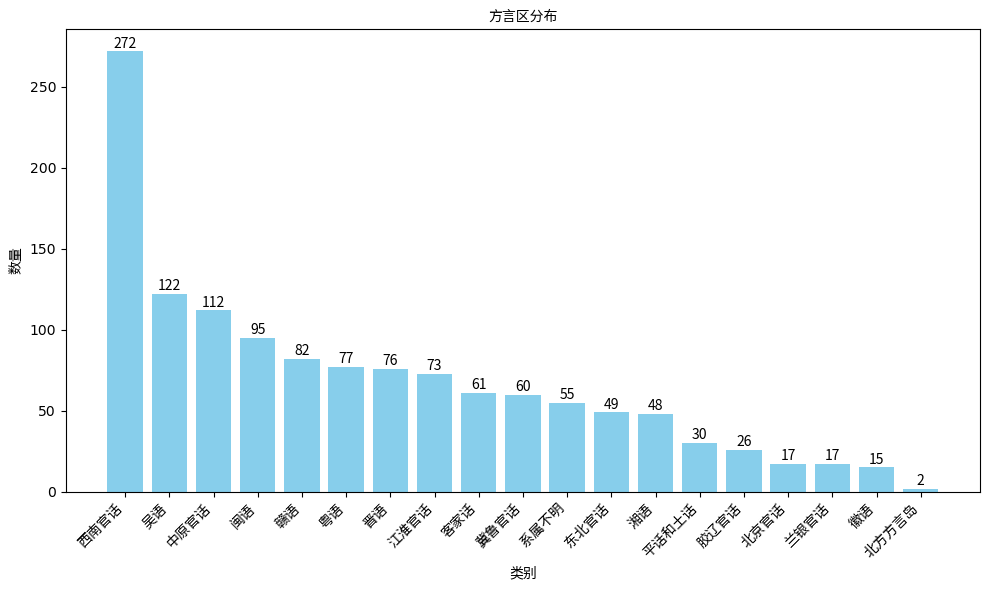

不同类别及其数量：
西南官话: 272
吴语: 122
中原官话: 112
闽语: 95
赣语: 82
粤语: 77
晋语: 76
江淮官话: 73
客家话: 61
冀鲁官话: 60
系属不明: 55
东北官话: 49
湘语: 48
平话和土话: 30
胶辽官话: 26
北京官话: 17
兰银官话: 17
徽语: 15
北方方言岛: 2


In [ ]:
areas = load_feats(name='Data4', features=['areas'])['areas']
my_font_path = 'utils/NotoSansSC-Regular.ttf'
categories, counts = count_and_plot_categories(areas, font_path=my_font_path, title="方言区分布")
if categories is not None:
    print("不同类别及其数量：")
    for cat, count in zip(categories, counts):
        print(f"{cat}: {count}")

In [47]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

def feature_reduction(data, method='pca', n_components=2, **kwargs):
    """
    使用指定的降维方法对数据进行降维。

    Args:
        data (np.ndarray): 输入数据，形状为 (n_samples, n_features)。
        method (str): 降维方法，可选 'pca', 'tsne', 'isomap'。默认为 'pca'。
        n_components (int): 目标维度。默认为 2。
        **kwargs: 传递给对应降维方法的额外参数。

    Returns:
        np.ndarray: 降维后的数据，形状为 (n_samples, n_components)。
                    如果方法不可用或发生错误，返回 None。
    """
    valid_methods = ['pca', 'tsne', 'isomap']
    method = method.lower() # 转换为小写以忽略大小写

    if method not in valid_methods:
        print(f"Error: Invalid method '{method}'. Available methods are: {', '.join(valid_methods)}")
        return None

    print(f"Applying {method.upper()} dimensionality reduction to {n_components} components...")

    try:
        if method == 'pca':
            model = PCA(n_components=n_components, **kwargs)
            reduced_data = model.fit_transform(data)
            print("PCA applied successfully.")
            return reduced_data

        elif method == 'tsne':
            # t-SNE 通常用于可视化，不适用于高维输出
            if n_components > 3:
                 print("Warning: t-SNE is typically used for 2 or 3 dimensions for visualization.")
            model = TSNE(n_components=n_components, **kwargs)
            reduced_data = model.fit_transform(data)
            print("t-SNE applied successfully.")
            return reduced_data

        elif method == 'isomap':
            model = Isomap(n_components=n_components, **kwargs)
            reduced_data = model.fit_transform(data)
            print("Isomap applied successfully.")
            return reduced_data

    except Exception as e:
        print(f"Error applying {method.upper()}: {e}")
        return None

In [49]:
distance = load_feats(name='Data4', features=['overall_distance'])['overall_distance']
distance_pca = feature_reduction(distance, method='pca', n_components=2)

Applying PCA dimensionality reduction to 2 components...
Error applying PCA: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [54]:
# 找到 NaN 值的布尔掩码
nan_mask = np.isnan(distance)

# 使用 np.where() 获取 NaN 值的索引
# np.where() 返回一个元组，每个元素是对应维度的索引数组
missing_value_locations = np.where(nan_mask)

# 输出索引位置
print("Missing value locations (row_indices, col_indices):")
print(missing_value_locations)

# 你也可以按 (row, col) 对的形式输出
print("\nMissing value locations (pairs of [row, col]):")
# zip missing_value_locations 就可以将不同维度的索引配对
for row, col in zip(missing_value_locations[0], missing_value_locations[1]):
    print(f"[{row}, {col}]")


Missing value locations (row_indices, col_indices):
(array([ 187, 1264]), array([1264,  187]))

Missing value locations (pairs of [row, col]):
[187, 1264]
[1264, 187]


In [ ]:
def plot_2d_embedding_improved(X,                   # 2D 数据 (n_samples, 2)
                               y_labels,            # 每个点的标签 (n_samples,)
                               plot_title,          # 图表标题 (字符串)
                               save_path,           # 保存图片的完整路径 (e.g., './plots/pca.png')
                               label_title="区域/标签", # 图例标题
                               font_prop=None,      # 传递获取到的 FontProperties 对象
                               use_adjust_text=True # 是否使用 adjustText
                              ):
    """
    生成并保存降维结果的 2D 散点图 (改进版，支持中文)。
    """
    print(f"\n--- Plotting: {plot_title} ---")
    # --- 输入验证 ---
    if X is None:
        print("Error: Input data 'X' is None. Skipping plot.")
        return
    if not isinstance(X, np.ndarray) or X.ndim != 2 or X.shape[1] != 2:
        print(f"Error: Input data 'X' must be a 2D NumPy array (shape={X.shape}). Skipping plot.")
        return
    if y_labels is None or len(y_labels) != X.shape[0]:
        print(f"Error: 'y_labels' is None or its length ({len(y_labels) if y_labels is not None else 'None'}) does not match number of data points ({X.shape[0]}). Skipping plot.")
        return

    # --- 确保保存目录存在 ---
    save_dir = os.path.dirname(save_path)
    if save_dir and not os.path.exists(save_dir):
        try:
            os.makedirs(save_dir)
            print(f"Created save directory: {save_dir}")
        except OSError as e:
            print(f"Error creating save directory {save_dir}: {e}. Cannot save plot.")
            return

    # --- 绘图设置 ---
    plt.figure(figsize=(12, 9))
    ax = plt.gca() # Get current axes

    unique_labels = np.unique(y_labels)
    num_unique_labels = len(unique_labels)

    # --- 获取颜色映射 (修正 get_cmap 用法) ---
    try:
        # 使用 plt.get_cmap 或 matplotlib.colormaps.get_cmap
        cmap = plt.get_cmap('tab20', num_unique_labels)
    except (ValueError, TypeError) as e: # 处理找不到 Colormap 或 num_labels 参数不支持的情况
        print(f"Warning: Colormap 'tab20' issue ({e}). Falling back to 'viridis'.")
        try:
             cmap = plt.get_cmap('viridis', num_unique_labels) # 备用方案
        except TypeError: # 如果 viridis 也不支持 num_unique_labels
             cmap = plt.get_cmap('viridis')
             print("Warning: Fallback 'viridis' also doesn't support num_unique_labels argument. Using default colors.")

    markers = ['o', 's', '^', 'P', '*', 'X', 'D', 'v', '<', '>'] * (num_unique_labels // 10 + 1)

    handles = [] # 用于图例
    texts = []   # 用于 adjustText

    # --- 绘制散点和文本标签 ---
    for i, name in enumerate(unique_labels):
        indices = np.where(y_labels == name)[0]
        # 获取颜色时进行归一化处理
        color_val = i / max(1, num_unique_labels - 1) if num_unique_labels > 1 else 0.5
        try:
            color = cmap(color_val)
        except TypeError: # 如果 cmap 不支持 num_unique_labels, 它可能返回 Colormap 对象而不是函数
             # 使用 Colormap 对象的 colors 列表
             color = cmap.colors[i % len(cmap.colors)]
             if i >= len(cmap.colors):
                  print(f"Warning: Not enough distinct colors in chosen colormap ({len(cmap.colors)}). Colors will repeat for label '{name}'.")

        marker = markers[i % len(markers)]

        # 绘制散点
        scatter = ax.scatter(X[indices, 0], X[indices, 1],
                           color=color, marker=marker, label=str(name), # 确保标签是字符串
                           s=60, alpha=0.8, edgecolors='w', linewidth=0.5)
        handles.append(scatter) # 添加到图例句柄

        # 为每个点添加文本标签 (使用 font_prop)
        for idx in indices:
            label_text = str(y_labels[idx]) # 确保标签是字符串
            text_args = {'fontsize': 9, 'alpha': 0.8}
            if font_prop:
                 text_args['fontproperties'] = font_prop # 应用字体属性

            texts.append(ax.text(X[idx, 0], X[idx, 1], label_text, **text_args))


    # --- 使用 adjustText 防止标签重叠 ---
    should_adjust = use_adjust_text and adjust_text_available and texts
    if should_adjust:
         print("Applying adjust_text to prevent label overlap...")
         try:
             adjust_text(texts, ax=ax,
                         arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=0.6),
                         force_text=(0.2, 0.5), force_points=(0.1, 0.2),
                         expand_points=(1.1, 1.1))
             print("adjust_text applied.")
         except Exception as e:
             print(f"Error during adjust_text: {e}")
    elif use_adjust_text and not adjust_text_available:
         print("adjustText not available or not installed, labels may overlap.")
    elif not texts:
         print("No text labels generated.")

    # --- 设置标题、轴标签和网格 (使用 font_prop) ---
    title_props = {'fontsize': 16, 'fontweight': 'bold'}
    label_props = {'fontsize': 12}
    if font_prop:
        title_props['fontproperties'] = font_prop
        label_props['fontproperties'] = font_prop

    ax.set_title(plot_title, **title_props)
    ax.set_xlabel('Component 1', **label_props)
    ax.set_ylabel('Component 2', **label_props)
    ax.grid(True, linestyle='--', alpha=0.5)

    # --- 创建图例 (使用 font_prop) ---
    legend_labels = [str(name) for name in unique_labels] # 确保图例标签是字符串
    ncol = 1 if num_unique_labels <= 10 else 2
    legend_kwargs = {'loc': 'upper left', 'bbox_to_anchor': (1.03, 1.0),
                     'title': label_title, 'ncol': ncol,
                     'fontsize': 10, 'markerscale': 1.0}
    if font_prop:
        legend_kwargs['prop'] = font_prop # 应用于图例条目
        legend_title_font = font_prop.copy()
        legend_title_font.set_size(12) # 设置图例标题大小
        legend_kwargs['title_fontproperties'] = legend_title_font

    # 仅当有句柄时才创建图例，避免无数据时报错
    if handles:
        ax.legend(handles=handles, labels=legend_labels, **legend_kwargs)
        # --- 调整布局以适应图例 ---
        plt.subplots_adjust(right=0.78 if ncol == 1 else 0.72) # 根据图例列数微调
    else:
        print("Warning: No data points plotted, skipping legend creation.")


    # --- 保存图像 ---
    try:
         plt.savefig(save_path, dpi=300, bbox_inches='tight')
         print(f"Saved plot to {save_path}")
    except Exception as e:
         print(f"Error saving plot {save_path}: {e}")
    finally:
        plt.close() # 确保图形关闭，释放内存

# --- 使用改进的函数绘图 ---
plot_2d_embedding_improved(X_fake,
                            y_labels_fake,
                            "城市分布模拟 (中文标签)", # <--- 中文标题
                            "./plot_chinese_labels_final.png", # 新文件名
                            label_title="城市名称",     # <--- 中文图例标题
                            font_prop=font_prop,       # <--- 传递字体对象
                            use_adjust_text=True)      # 使用 adjustText

plot_2d_embedding_improved(X_fake,
                            y_labels_fake_numeric,
                            "分布模拟 (数字标签)",
                            "./plot_numeric_labels_final.png", # 新文件名
                            label_title="所属类别",     # <--- 中文图例标题
                            font_prop=font_prop,       # <--- 传递字体对象
                            use_adjust_text=False)     # 禁用 adjustText

print("\n--- Plotting finished ---")

# End